In [166]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Get data
train_2016 = pd.read_csv('zillow-data/train_2016_v2.csv')
train_2017 = pd.read_csv('zillow-data/train_2017.csv')
properties_2016 = pd.read_csv('zillow-data/properties_2016.csv')
properties_2017 = pd.read_csv('zillow-data/properties_2017.csv')
sample_submission = pd.read_csv('zillow-data/sample_submission.csv')

# merge datasets
merged_data_2016 = pd.merge(properties_2016, train_2016, on='parcelid')
merged_data_2017 = pd.merge(properties_2017, train_2017, on='parcelid')
data = pd.concat([merged_data_2016, merged_data_2017], ignore_index=True)

#split data into x and y
selected_features = ['bedroomcnt', 'taxvaluedollarcnt', 'lotsizesquarefeet']
x = data[selected_features]
y = data['logerror']


/var/folders/j_/x6hw9dln68b5mhc56_pld0rh0000gn/T/ipykernel_3477/4045514864.py:11: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2016 = pd.read_csv('zillow-data/properties_2016.csv')
/var/folders/j_/x6hw9dln68b5mhc56_pld0rh0000gn/T/ipykernel_3477/4045514864.py:12: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2017 = pd.read_csv('zillow-data/properties_2017.csv')


In [167]:
# Check for missing values in selected features
missing_values = x.isnull().sum()
print(missing_values)


bedroomcnt              34
taxvaluedollarcnt       36
lotsizesquarefeet    18442
dtype: int64


In [168]:
#fill missing values with median
x = x.fillna(x.mean())
print(x.isnull().sum().sum())

#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

0


### Standardize the data

In [169]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform() to avoid data leakage

# Convert back to DataFrame (optional, but helpful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Check if scaling worked
# Mean should be super small, Std should be super close to 1
print(X_train_scaled.describe())  

         bedroomcnt  taxvaluedollarcnt  lotsizesquarefeet
count  1.343100e+05       1.343100e+05       1.343100e+05
mean   5.536583e-16      -1.608257e-16       5.057545e-17
std    1.000004e+00       1.000004e+00       1.000004e+00
min   -2.651662e+00      -7.692864e-01      -2.552584e-01
25%   -9.076079e-01      -4.405611e-01      -2.046477e-01
50%   -3.558079e-02      -2.012289e-01      -1.904648e-01
75%    8.364463e-01       1.300480e-01      -6.529321e-02
max    1.130077e+01       7.895333e+01       6.069838e+01


In [170]:
from sklearn.model_selection import GridSearchCV

# Grid search for best alpha
param_grid = {'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]}
grid_search = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5)


grid_search.fit(X_train_scaled, y_train)

print("Best Alpha:", grid_search.best_params_['alpha'])
print("Best MSE:", -grid_search.best_score_)

Best Alpha: 0.0001
Best MSE: 0.027100006070591674


In [171]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lasso = Lasso(alpha=.00001)
lasso.fit(X_train_scaled, y_train)

# Get training predictions
y_train_pred = lasso.predict(X_train_scaled)

# Calculate training MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training MAE: {train_mae}")
print(f"Training MSE: {train_mse}")
print(f"Training R^2 Score: {train_r2}")

Training MAE: 0.06946406634977421
Training MSE: 0.027098147976138312
Training R^2 Score: 0.0009112989063785326


In [172]:
# make predictions on the test data
y_pred = lasso.predict(X_test_scaled)


# eval the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)


print(f" TESTING Mean Absolute Error: {mae}")
print(f" TESTING Mean Squared Error: {mse}")
print(f" TESTING R^2 Score: {r2}")

 TESTING Mean Absolute Error: 0.06943482198986815
 TESTING Mean Squared Error: 0.028773020834360227
 TESTING R^2 Score: 0.0009325670388559137


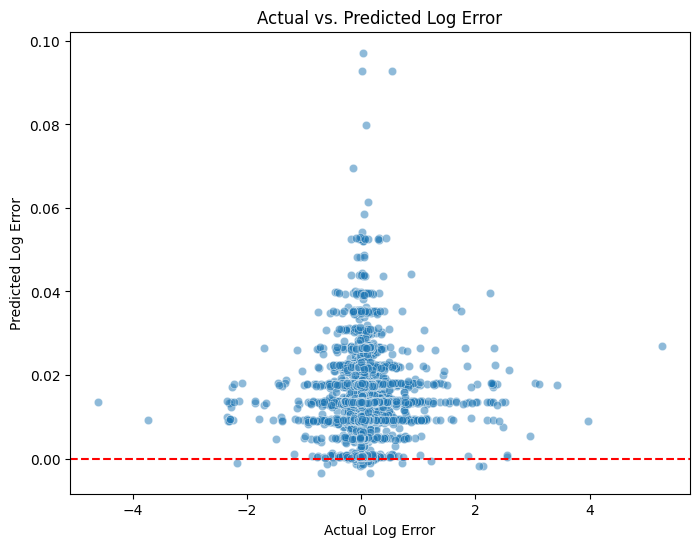

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Actual vs. Predicted Values
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Actual vs. Predicted Log Error")
plt.axhline(y=0, color='r', linestyle='--')  # Line for perfect predictions
plt.show()


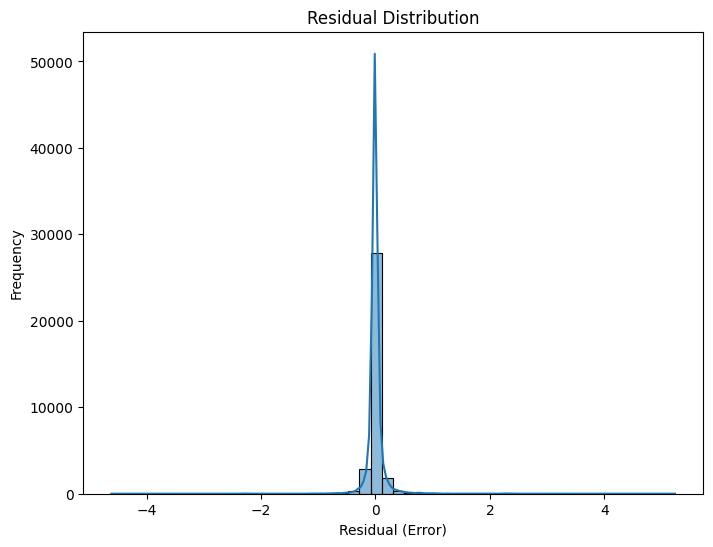

In [174]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals distribution
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [175]:
# Extract parcel IDs
parcel_ids = sample_submission['ParcelId']

# Ensure your test data includes only these parcel IDs
test_data = properties_2017[properties_2017['parcelid'].isin(parcel_ids)]

X_test = test_data[selected_features]
X_test = X_test.fillna(X_test.median())

# Apply the same feature scaling as used in training
X_test_scaled = scaler.transform(X_test)  # Use the same scaler from training!
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print(X_test_scaled)

# Predict log errors for the test set
predictions = lasso.predict(X_test_scaled)

         bedroomcnt  taxvaluedollarcnt  lotsizesquarefeet
0         -2.651662          -0.769308           0.493244
1         -2.651662          -0.724610          -0.221017
2         -2.651662           1.562403           0.294902
3         -2.651662           1.139155          -0.190954
4         -2.651662          -0.054175          -0.182289
...             ...                ...                ...
2985212   -0.035581          -0.247448          -0.195510
2985213   -0.035581          -0.247448          -0.195510
2985214   -0.035581          -0.247448          -0.195510
2985215   -0.035581          -0.247448          -0.195510
2985216   -0.035581          -0.247448          -0.195510

[2985217 rows x 3 columns]


## GENERATE SUBMISSION

In [176]:
submission_df = pd.DataFrame({'ParcelId': parcel_ids})

# Add predictions for each required time period
for time_point in ['201610', '201611', '201612', '201710', '201711', '201712']:
    submission_df[time_point] = np.round(predictions, 4)  # Round to 4 decimal places

submission_df.to_csv('lasso_submission.csv', index=False)